# Advanced deep learning project: An exploratory analysis of data augmentation techniques 

### Student: Mariana Chaves 


## Introduction 

In this study, we explore some data augmentation techniques to compare their impact on the accuracy of an image classification model. Data augmentation, as its name suggests, comprehends techniques used to increase the amount of data by adding modified copies of the original data or by creating synthetic data. It aims, not only to increase the size of the data to feed data-hungry models but also to enhance the quality of the training dataset since is it used to avoid overfitting (Shorten & Khoshgoftaar, 2019). 

There are many techniques, among them we can mention geometric transformations, color space augmentations, kernel filters, mixing images, random erasing, feature space augmentation, adversarial training, generative adversarial networks, and many others. We focus on four:

* Deep convolutional generative adversarial networks (DCGAN)
* Denoising autoencoder (DEA)
* Convolutional variational autoencoder (CVAE)
* Geometric transformations

## Materials and methods 

### Datasets

We choose four datasets from the MedMNIST (Yang et al., 2021) collection:

* PneumoniaMNIST: it includes 5856 pediatric chest X-Ray black and white images. The task is a binary-class classification of pneumonia against normal.
* BreastMNIST: it contains 780 breast ultrasound black and white images. The task is binary-class of normal/benign against malignant. 
* BloodMNIST: this dataset is based on individual normal blood cells, captured from individuals without infection, hematologic or oncologic disease, and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17092 RGB images and is organized into 8 classes. 
* DermaMNIST: it contains 10015 dermatoscopic images of common pigmented skin lesions. It is categorized into 7 different diseases.

### Data augmentation techniques 

The first data augmentation technique that we apply is Deep convolutional generative adversarial networks (DCGAN) (Radford et al., 2015), which follows the same idea as a regular GAN, that is, it trains two networks: a generator and a discriminator. The generator learns to create images that look real, while a discriminator learns to tell real images apart from generated ones. It differs from the original GAN since it uses CNNs instead of only dense layers. 

Secondly, we apply a Denoising autoencoder. Autoencoders englobe an encoder and a decoder. The encoder reduces the dimensionality of the data, that is, it brings it to a latent space. Then the decoder takes the latent representation and tries to reconstruct the data, such that the output of the decoder is as similar as possible to the original data. Denoising autoencoders use corrupted data points as input and train to predict the original. In our case, the corrupted data points are images with Gaussian noise. The DEA trains to reconstruct the original, not noisy, images. 

The third technique is a Convolutional variational autoencoder (CVAE) (Kingma & Welling, 2013). In the same spirit as the autoencoder, an encoder network reduces the data to a latent representation. Nevertheless, in this case, the VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian distribution, as in our code. Instead of forwarding the latent values to the decoder directly, VAEs use them to calculate the mean and the standard deviation. The input to the decoder is then sampled from the corresponding normal distribution.

Finally, we experiment with geometric data augmentation. There are many possible geometric transformations such as flipping, cropping, rotation, noise injection, and others. We implement flippling of the images and then a rotation (which can be of 0, 90, 180, or 270 degrees). 

In all cases, we increase the training set by 50%. Therefore, the augmented data contains one-third or generated new images. 
We take care of incrementing the data proportionally to the class size. In other words, if in the original data a class represented 30% of the images, the augmented data keep that proportion. For the data augmentation using DCGANs, a DCGAN was trained for each class in each dataset. The same strategy was used for the CVAE models.  

### The classifier 

We use Autokeras (Jin et al., 2019) as classifier. It was one of the classifiers used by the authors of MedMNIST on the different datasets. AutoKeras is an AutoML tool for deep learning models. It performs a search on Keras models via TensorFlow. 

## Code

In this section, we present all the functions developed for this study. For each model, we refer to the works on which the code was based, but several modifications were made to the architectures in some cases.  

### Libraries

We start by installing the necessary libraries.

In [1]:
!pip install autokeras                                          
!pip install medmnist

     |████████████████████████████████| 160 kB 4.2 MB/s 
     |████████████████████████████████| 98 kB 9.1 MB/s 
     |████████████████████████████████| 462 kB 55.1 MB/s 
     |████████████████████████████████| 87 kB 3.4 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=30d55bb19f2024311814900ac4e0c7499877274d4d78143b49307f972a959af8
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [2]:
from tqdm import tqdm
import numpy as np    
import medmnist
from medmnist import INFO, Evaluator
import pickle
import os
from PIL import Image
import random
import glob
import time
from skimage.transform import rotate
import pandas as pd
import autokeras as ak
import cv2
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils

from IPython.display import HTML
from IPython import display

### Data loading and handling

In this section we define some functions related to data loading, saving and plotting: 
* load_data: Given a string defining the MedMNIST dataset (e.g. bloodminist), it loads the train, test, validation sets and other information about the dataset.
* split_long_strings: It's a function to handle long class names. It splits the class name using a change of line (\n). This function is use inside the a plotting function to make better looking titles in the plot. 
* plot_images_of_each_class: Given a dataset, it displays example images of each class. 
* save_images_in_folders: it creates a folder with the name of the dataset (e.g. bloodminist), and inside it, it creates a folder for each class including its images. This way of organizing the images and folders is necessary for the DCGAN model. 

In [3]:
def load_data(data_name):
  '''
  Given one of the MedMNIST dataset names, this function loads the train, validation and test datasets
  '''

  info = INFO[data_name]
  class_names = info['label']
  image_channels = info['n_channels']

  data_path = tf.keras.utils.get_file(origin=info['url'], md5_hash=info['MD5'])

  with np.load(data_path) as data:
      # Get images
      train_images = data['train_images']
      val_images = data['val_images']
      test_images = data['test_images']

      # Get labels
      train_labels = data['train_labels'].flatten()
      val_labels = data['val_labels'].flatten()
      test_labels = data['test_labels'].flatten()


  return train_images, val_images, test_images, train_labels, val_labels, test_labels, class_names, image_channels, data_name


In [38]:
def split_long_strings(s, size = 15):
  '''
  This function adds a change of line (\n) when a string is too long. 
  This is usefull for the title of plots
  For example for a string "Hello, How are you?" and a size of 7 becomes "Hello, \n How \n are you?"

  Inputs: 
    s: a string
    size: the maximum size after which we cut 
  '''

  if len(s) > size:

    #index where spaces are
    space_idx = [idx for idx,letter in enumerate(s) if(letter == ' ')]

    #index where we would do the cut (but we won't because we want to cut on the spaces, not in the middle of the word)  
    cuts_idx = np.array(range(len(s) // size))[1:] * size
    #index where we cut
    space_cuts_idx = [space_idx[np.where((space_idx - i) > 0, space_idx - i, np.inf).argmin()] for i in cuts_idx]

    # Add end of line in the selected spaces
    for i in space_cuts_idx:
      temp = list(s)
      temp[i] = '*'
      s = "".join(temp)

    s = s.replace('*', ' \n ')

  return s

In [41]:
def plot_images_of_each_class(n_examples, #number of examples per class (this determines the number of rows in the plot)
                              images, #np array of images 
                              labels, #np array of labels
                              class_names): #dictionary of classes (ex: {'0':Class1, '1':Class2})
  n_rows = n_examples
  n_cols = len(class_names)

  # Defining figure dimensions
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=False, sharey=False, figsize=(n_cols*2, n_rows*2))
  axes = axes.ravel()
  # Do not show axis
  [axi.set_axis_off() for axi in axes.ravel()]

  for i in range(len(class_names)):
    # Subset of images
    subset_images = images[labels == i]
    
    title = split_long_strings(class_names[str(i)], size = 10)
    axes[i].set_title(title)

    for j in range(n_rows):
      # Display in gray or not depending of the number of channels
      if len(images.shape) < 4:
        axes[(j*n_cols)+i].imshow(subset_images[j], cmap = 'gray')
      else:
        axes[(j*n_cols)+i].imshow(subset_images[j])

  return fig


In [6]:
def save_images_in_folders(data_name, train_images, train_labels, class_names): 
  '''
  This function saves images in folders according to their class
  '''
  
  # Create a folder for the data 
  os.mkdir(data_name)

  # Create a folder for each class
  for i in range(len(class_names)):
    folder = data_name + '/' + str(i)
    os.mkdir(folder)
    # Subset of images
    subset_train_images = train_images[train_labels == i]
    # Save the images in each folder
    for j in range(len(subset_train_images)):
      im = Image.fromarray(subset_train_images[j])
      im.save(folder + '/' + str(j) + ".png")

In [7]:
def save_to_pickle(list_of_objects, names_for_files, data_name):
  '''
  Given a list of of objects and corresponding file name for each object, it saves the objects in pickle files 
  '''
  
  for obj, name in zip(list_of_objects, names_for_files): 
    with open(data_name + name +'.pickle', 'wb') as f:
        pickle.dump(obj, f)


### Autokeras

In the next function we prepare the data to be use in the autokeras classifier. The model is fitted and the accuracy results are returned by the function. 

In [8]:
def use_autokeras(train_images, train_labels, val_images, val_labels, test_images, test_labels, class_names, max_trials = 1, seed=None):
  '''
  This function fits the model using autokeras and returns the classifier and the accuracy in train, val and test sets. 
  Predictions can be made using model.predict (ex: clf.predict(test_images))
  ''' 
  # If there are only 2 classes, don't one-hot encode labels
  if len(class_names) == 2:
    train_labels_one_hot = train_labels
    val_labels_one_hot = val_labels
    test_labels_one_hot = test_labels
  # if there are more than 2 class, then use one-hot encoding.
  else:
    eye = np.eye(len(class_names))
    train_labels_one_hot = eye[train_labels]
    val_labels_one_hot = eye[val_labels]
    test_labels_one_hot = eye[test_labels]

  # Initialize the image classifier.
  clf = ak.ImageClassifier(overwrite=True, max_trials=max_trials, seed=seed)
  # Feed the image classifier with training data.
  clf.fit(train_images, train_labels_one_hot, validation_data=(val_images, val_labels_one_hot), epochs=10)

  # Evaluate the best model with testing data.
  loss_train, accuracy_train = clf.evaluate(train_images, train_labels_one_hot)
  loss_val, accuracy_val = clf.evaluate(val_images, val_labels_one_hot)
  loss_test, accuracy_test = clf.evaluate(test_images, test_labels_one_hot)

  return {'accuracy_train':accuracy_train, 'accuracy_val':accuracy_val, 'accuracy_test': accuracy_test}


### DCGAN

In the next cells, we define the functions and classes necessary to train the DCGAN model and generate images from it. 

This code is based on the work available in https://colab.research.google.com/drive/1c4w8h0MG6SeQQxI1OexKWNzaZmEe5tBt?usp=sharing#scrollTo=ITPqI9_KxtIA, https://www.tensorflow.org/tutorials/generative/dcgan, and https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/#coding-dcgan

In [9]:
# Define class for the data loader
class Disease(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform 
        self.root = root
        self.imgs = glob.glob(self.root + '*')

    def __getitem__(self, idx):
        """Get items.
        Args:
            index (int): Index
        Returns:
            img: PIL Image.
        """
        img = self.imgs[idx]
        img = Image.open(img).convert('RGB')

        if self.transform is not None: #to normalize all the images
            img = self.transform(img)

        return img

    def __len__(self):
        """Get length."""
        return len(self.imgs)

In [10]:
# Network weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)      # N(0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)      # N(1,0.02)
        m.bias.data.fill_(0)

In [11]:
# Generator

# Architecture: 
"""
* 1st layer:
transposed convolution
batch norm
relu

* 2nd layer
transposed convolution
batch norm
relu

* 3rd layer
transposed convolution
batch norm
relu

* 4th layer
transposed convolution
batch norm
relu

* 5th layer
transposed convolution
tanh
"""


# Define the Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # TODO:

          # input = bs * 100 * 1 * 1
          # output = bs * 3 * 64 * 64

        # Help of the Sequential module   
        self.net = nn.Sequential(   
        # 1st layer output: bs * 512 * 4 * 4
          nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=True), #input is a vector of 100 entries from a gaussian, output 512, kernel_size = 4, stride=1, padding=0
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),
        # 2nd layer output: bs * 256 * 8 * 8    
          nn.ConvTranspose2d(512, 256, 4, 2, 1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
        # 3rd layer output: bs * 128 * 16 * 16
          nn.ConvTranspose2d(256, 128, 4, 2, 1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
        # 4th layer output: bs * 64 * 32 * 32
          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(True),
        # 5th layer output: bs * 3 * 64 * 64
          nn.ConvTranspose2d(64, 3, 4, 2, 1),
          nn.Tanh()
        )
    def forward(self, x):
      
        out = self.net(x)

        return out

In [12]:
# Discriminator

# Architecture: 
"""
* 1st layer:
convolution
Leakyrelu

* 2nd layer
convolution
batch norm
Leakyrelu

* 3rd layer
convolution
batch norm
Leakyrelu

* 4th layer
convolution
batch norm
Leakyrelu

* 5th layer
convolution
sigmoid
"""


# Define the Discriminator Network

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
        # 1st layer output: bs * 64 * 32 * 32
          nn.Conv2d(3, 64, 4, 2, 1),
          #nn.ReLU(True),
          nn.LeakyReLU(0.2, True),
        # 2nd layer output: bs * 128 * 16 * 16    
          nn.Conv2d(64, 128, 4, 2, 1),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, True),
        # 3rd layer output: bs * 256 * 8 * 8
          nn.Conv2d(128, 256, 4, 2, 1),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, True),
        # 4th layer output: bs * 512 * 4 * 4
          nn.Conv2d(256, 512, 4, 2, 1),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2, True),
        # 5th layer output: bs * 1
          nn.Conv2d(512, 1, 4, 1, 0),
          nn.Sigmoid()
        )
    def forward(self, x):

        out = self.net(x)

        return out.squeeze(-1).squeeze(-1)

In [13]:
# Set device - we use GPU 
device = torch.device("cuda:0")

In [14]:
# DCGAN function
def DCGAN(folder, # folder name where the images live (ex:'bloodmnist/0/', './bloodmnist/0/')
          batch_size = 128, 
          beta1 = 0.5,       # for the optimization function 
          lr = 2e-4,         # learning rate 
          nz = 100,          # input dimension 
          num_epochs = 100,  
          num_workers = 2):
  
  '''
  This function returns the generator and prints examples of the generated images.  
  ''' 
    
  # Define parameters 

  batch_size = 128  
  beta1 = 0.5       # for the optimization function 
  lr = 2e-4         # learning rate 
  nz = 100          # input dimension 
  num_epochs = 100  
  num_workers = 2

  # define G, D and initialize parameters
  netG = Generator().to(device)
  netD = Discriminator().to(device)
  netG.apply(weights_init)
  netD.apply(weights_init)

  # Function to display demos
  def display_demos(fixed_noise, epoch, iters):
    img_list = []
    with torch.no_grad():
      fake = netG(fixed_noise).detach().cpu()
      plt.rcParams["figure.figsize"]=10,10
      plt.clf()
      plt.title('epoch: %d iteration: %d'%(epoch, iters))
      imgs = make_grid(fake.data*0.5+0.5).cpu() # CHW
      plt.imshow(imgs.permute(1,2,0).numpy())
      display.display(plt.gcf())
      display.clear_output(wait=True)
      time.sleep(0.5)

  # print(netG)
  # print(netD)

  # define loss function 
  criterion = nn.BCELoss().to(device) 

  #img_list for loss
  G_losses = []
  D_losses = []
  iters = 0

  # Create batch of latent vectors (64 * nz * 1 * 1) that we will use to visualize
  fixed_noise = torch.randn(64, 100, 1, 1).to(device)

  # Setup Adam optimizers for both G and D
  optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

  # normalize all image included on the loaded dataset : 
  train_transform = transforms.Compose([transforms.Resize((64,64)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # Load data
  dataset = Disease(root=folder, transform=train_transform)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

  print("==> start training")
  for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
      ############################
      # Update D network
      # maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      # put data into gpu
      real_imgs = data.to(device)

      ## Train with all-real batches
      # set D gradient 0
      netD.zero_grad()

      # Forward pass real batch through D
      output = netD(real_imgs)

      # set ground truth label 1
      label_real = torch.ones(output.size()).to(device)

      # Calculate loss on all-real batch
      errD_real = criterion(output, label_real)

      # Calculate gradients for D in backward pass
      errD_real.backward()

      ## Train with all-fake batch
      # Generate batch of latent vectors
      noises = torch.randn(output.size(0), 100, 1, 1).to(device)

      # Generate fake image batch with G
      fake = netG(noises)

      # Classify all fake batch with D
      output = netD(fake.detach())

      # set ground truth label 0
      label_fake = torch.zeros(output.size()).to(device)

      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(output, label_fake)

      # Calculate the gradients for this batch
      errD_fake.backward()

      # Add the gradients from the all-real and all-fake batches
      errD = errD_real + errD_fake

      # Update D
      optimizerD.step()

      ############################
      # Update G network
      # maximize log(D(G(z)))
      ###########################
      # set G gradient 0
      netG.zero_grad()

      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = netD(fake)

      # Calculate G's loss based on this output
      errG = criterion(output, label_real)

      # Calculate gradients for G
      errG.backward()

      # Update G
      optimizerG.step()

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())

      # display demo images each 50 iterations
      if iters % 50 == 0:
        display_demos(fixed_noise, epoch, iters)

      iters += 1

  return netG


In [15]:
def generate_new_images_DCGAN(n_new_images, # number of images to generate
                        generator): # the generator (returned by DCGAN)

  # Generate some noise
  noises = torch.randn(n_new_images, 100, 1, 1).to(device)
  # Generate image batch with G
  new_images = generator(noises)
  # Resize images
  new_images = transforms.Resize((28,28))(new_images)
  # Convert tensor to np array
  new_images = new_images.cpu().detach().numpy()
  # Chance from channel x H x W to H x W x channel  
  new_images = np.moveaxis(new_images, 1, -1)
  # Scale 0 to 255 (RGB)
  new_images = np.rint((new_images + 1) / 2 * 255). astype(int)

  return new_images

In [16]:
def augment_data_DCGAN(data_name, images, labels, percent):
  '''
  This function trains a DCGAN for each class in a dataset, and generates new images. 
  A percent of new images to generate must be given (ex: generate 20% more images of each class). 
  The outpout is the augmented images and labels and a list containing the GAN generator for each class.  

  Inputs:
    data_name: name of the dataset, this determines the folder where the images live.
    images: an array of images
    labels: 1D np array of labels
    percent: the percent of the images that we want to reconstruct
  '''
  #Objects to save images, labels and generator
  augmented_images = images
  augmented_labels = labels
  generators = []

  for i in tqdm(np.unique(labels)):
  
    print(i)
    # Train the DCGAN
    gen = DCGAN(folder = data_name+'/' + str(i) +'/')
    # Save generator
    generators.append(gen)
    
    # Number of images to generate
    n_new_images = int(sum(labels == i) * percent)
    
    # generate images
    new_images = generate_new_images_DCGAN(n_new_images, gen)

    # if the original images where black and white, correct to have the right dimensions
    if len(images.shape) == 3:
      new_images = np.array(new_images, dtype=np.uint8)
      new_images = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in new_images])

    # update augmented_train_images
    augmented_images = np.concatenate((augmented_images, new_images))

    # update augmented_train_labels
    augmented_labels = np.concatenate((augmented_labels, np.full(n_new_images, i)))

  return augmented_images, augmented_labels, generators

### Denoising Autoencoder

In the next cells, we define the functions related to the denoising autoencoder.

This code is based on the work available in https://www.tensorflow.org/tutorials/generative/autoencoder.

In [17]:
def DEA(train_images, val_images, noise_factor=0.2):
    '''
    This function makes the necessary transformations to the data and trains an autoencoder.
    The output is the trained autoencoder.

    We can access the architecture using autoencoder.encoder.summary() or autoencoder.decoder.summary()

    '''
    # Change from 0 - 255 to 0 - 1
    train_images_scaled = train_images.astype('float32') / 255.
    val_images_scaled = val_images.astype('float32') / 255.

    # Add a new axis if the images have just one channel
    if len(train_images.shape) == 3 :
      train_images_scaled = train_images_scaled[..., tf.newaxis]
      val_images_scaled = val_images_scaled[..., tf.newaxis]

    # Adding noise to images 
    train_images_noisy = train_images_scaled + noise_factor * tf.random.normal(shape=train_images_scaled.shape) 
    val_images_noisy = val_images_scaled + noise_factor * tf.random.normal(shape=val_images_scaled.shape) 

    train_images_noisy = tf.clip_by_value(train_images_noisy, clip_value_min=0., clip_value_max=1.)
    val_images_noisy = tf.clip_by_value(val_images_noisy, clip_value_min=0., clip_value_max=1.)

    #number of channels
    n_channels = train_images_scaled.shape[3]

    class Denoise(Model):
      def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, n_channels)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(n_channels, kernel_size=(3, 3), activation='sigmoid', padding='same')])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = Denoise()

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(train_images_noisy, train_images_scaled,
                epochs=10,
                shuffle=True,
                validation_data=(val_images_noisy, val_images_scaled))
    
    return autoencoder
    


In [18]:
def generate_new_images_DEA(images, autoencoder):
  # Change from 0 - 255 to 0 - 1
  images_scaled = images.astype('float32') / 255.

  #Generate images
  encoded_imgs = autoencoder.encoder(images_scaled).numpy()
  decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

  # Remove one dimension if the original images where of 1 channel
  number_of_channels = decoded_imgs.shape[3]
  if number_of_channels == 1:
    decoded_imgs = tf.squeeze(decoded_imgs)

  return decoded_imgs
  

In [19]:
def augment_data_DAE(images, labels, autoencoder, percent):
  '''
  It generates new images given a set of images, a trained autoencoder, and a percent of the images to generate (ex: apply the autoencoder to just 20% of the images). 
  It takes into consideration the classes. 

  Inputs:
    images: np array of images
    labels: 1D np array of labels
    autoencoder: an autoencoder
    percent: the percent of the images that we want to reconstruct
  '''

  #Generate images by class
  augmented_images = images
  augmented_labels = labels

  for i in np.unique(labels):
    # Get images of the class
    subset_images = images[labels == i]
    n = len(subset_images)

    # Take only a percent of the images
    n_new_images = np.rint(percent * n).astype(int)
    idx = np.random.choice(n, n_new_images, replace = False)

    # Reconstructed images
    decoded_imgs = generate_new_images_DEA(images[idx], autoencoder)

    # Update images and labels
    augmented_images = np.concatenate((augmented_images, decoded_imgs))
    augmented_labels = np.concatenate((augmented_labels, np.full(n_new_images, i)))

  return augmented_images, augmented_labels

In [20]:
def plot_originals_and_reconstructions_DEA(images, n_examples, autoencoder):
  '''
  This function plots the original image and the reconstruction image provided by an autoencoder. 
  Inputs:
    images: a numpy array of images
    n_examples: the number of images that we want to reconstruct and plot
    autoencoder: the autoencoder to use  
  '''
  # Some original images
  original_images = images[0:n_examples] 

  # Reconstructed images
  reconstructed_images = generate_new_images_DEA(images[0:n_examples], autoencoder)

  # Defining figure dimensions
  n_rows = 2
  n_cols = n_examples
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=False, sharey=False, figsize=(n_cols*2, n_rows*2))
  axes = axes.ravel()
  # Do not show axis
  [axi.set_axis_off() for axi in axes.ravel()]

  for i in range(n_examples):
    if len(images.shape) == 3:
      axes[i].imshow(original_images[i], cmap = 'gray')
      axes[i + n_examples].imshow(reconstructed_images[i], cmap = 'gray')
    else: 
      axes[i].imshow(original_images[i])
      axes[i + n_examples].imshow(reconstructed_images[i])
    
    if i == (n_examples // 2 ):
      axes[i].set_title('Original images')
      axes[i + n_examples].set_title('Reconstructed images')

  return fig

### Convolutional variational autoencoder

Now we define the functions and classes related to the convolutional variational autoencoder.

This code is based on the work available in https://keras.io/examples/generative/vae/ and https://www.tensorflow.org/tutorials/generative/cvae. 

In [21]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [23]:
def CVAE(images, latent_dim = 10, epochs = 30):
  '''
  This function trains a convolutional variation autoencoder. It provides the trained CVAE as output
  Inputs:
    images: np array of images
    latent_dim: the size of the latent dimension
    epochs: number of epochs
  '''
  # Add a new axis if the images have just one channel
  if len(images.shape) == 3 :
    images = images[..., tf.newaxis]

  #number of channels
  n_channels = images.shape[3]

  #latent dimension
  latent_dim = latent_dim

  #encoder
  encoder_inputs = keras.Input(shape=(28, 28, n_channels))
  x = layers.Conv2D(32*4*2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64*4*2, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16*4*2, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

  #decoder
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(7 * 7 * 64*4*2, activation="relu")(latent_inputs)
  x = layers.Reshape((7, 7, 64*4*2))(x)
  x = layers.Conv2DTranspose(64*4*2, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32*4*2, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(n_channels, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

  # Change from 0 - 255 to 0 - 1
  images = images.astype('float32') / 255.

  # Train the CVAE
  vae = VAE(encoder, decoder)
  vae.compile(optimizer=keras.optimizers.Adam())
  vae.fit(images, epochs=epochs, batch_size=128)

  return vae

In [24]:
def generate_new_images_CVAE(variational_autoencoder, number_images, latent_dim, low = -5, high = 5):
  '''
  Given a trained CVAE, and a number of images to generate it generates images.
  Inputs: 
    variational_autoencoder: a VCAE (the output of function CVAE)
    number_images: the number of images to generate
    latent_dim: size of the latent dimension
    low and high: parameters for the uniform distribution creating the input noise
  '''
  # Sampling noise from uniform distribution
  latent_noise = np.random.uniform(low=low, high=high, size=(number_images, latent_dim))
  # Generate images from noise 
  generated_images = variational_autoencoder.decoder.predict(latent_noise)

  # Remove one dimension if the original images where of 1 channel
  number_of_channels = generated_images.shape[3]
  if number_of_channels == 1:
    generated_images = tf.squeeze(generated_images)

  return generated_images

In [25]:
def augment_data_CVAE(images, labels, percent, latent_dim = 10, epochs=30):
  '''
  This function trains a CVAE for each class in a dataset, and generates new images. 
  A percent of new images to generate must be given (ex: generate 20% more images of each class). 
  The outpout is the augmented images and labels and a list containing the CVAE for each class.  

  Inputs:
    images: np array of images
    labels: 1D np array of labels
    percent: the percent of the images that we want to reconstruct
    epochs: number of epochs to train each variational autoencoder
  '''
  #Objects to save images, labels and CVAE
  augmented_images = images
  augmented_labels = labels
  CVAEs = []

  for i in tqdm(np.unique(labels)):
    # Images of class i
    subset_images = images[labels == i]
    # Number of images in class i
    n = len(subset_images)
    # Number of images to generate of this class given the percent 
    n_new_images = np.rint(percent * n).astype(int)

    # Train CVAE
    varautoen = CVAE(subset_images, latent_dim = latent_dim, epochs = epochs)
    # Save CVAE
    CVAEs.append(varautoen)

    # Generate images 
    generated_imgs = generate_new_images_CVAE(varautoen, n_new_images, latent_dim)

    # Update images and labels
    augmented_images = np.concatenate((augmented_images, generated_imgs))
    augmented_labels = np.concatenate((augmented_labels, np.full(n_new_images, i)))

  return augmented_images, augmented_labels, CVAEs



### Geometric data augmentation

The following cells contain the functions to perform the two geometric data augmentation techniques that we selected: rotation and image flipping.  

In [26]:
def flip_and_rotate(images, percent = 0.2):
  '''
  This function flips and rotates a percent of the images. The output is an array of the flipped and rotated images
  Inputs:
    images: an np.array of images from which to sample
    percent: the percent of the images to flip and rotate 
  '''

  # Number of images
  n = len(images)
  # Number of images to generate given the percent 
  n_new_images = np.rint(percent * n).astype(int)

  # random sample the images to flip
  idx = np.sort(np.random.choice(n, n_new_images, replace = False))
  # flip the selected images
  flipped_images = np.fliplr(images[idx])
  # rotate the selected images 
  flipped_rotated_images = np.array([rotate(i, np.random.choice([0,90,180,270], 1)) for i in flipped_images])

  return flipped_rotated_images

In [27]:
def augment_data_geometric(images, labels, percent):
  '''
  This function flips and rotates a percent of the images each class in a dataset. 
  A percent images flip and rotate must be given (ex: generate 20% more images of each class). 
  The outpout is the modified images and labels.  

  Inputs:
    images: np array of images
    labels: 1D np array of labels
    percent: the percent of the images that we want to reconstruct
  '''
  #Objects to save images and labels
  augmented_images = images
  augmented_labels = labels

  for i in np.unique(labels):
    # Images of class i
    subset_images = images[labels == i]
    # Number of images in class i
    n = len(subset_images)
    # Number of images to generate of this class given the percent 
    n_new_images = np.rint(percent * n).astype(int)

    # flip and rotate a percent of the images  
    modified_imgs = flip_and_rotate(subset_images, percent = percent)

    # Update images and labels
    augmented_images = np.concatenate((augmented_images, modified_imgs))
    augmented_labels = np.concatenate((augmented_labels, np.full(n_new_images, i)))

  return augmented_images, augmented_labels

In [28]:
def plot_originals_and_rotated_flipped(images, n_examples):
  '''
  This function plots the original image and its flipped and rotated version. 
  Inputs:
    images: a numpy array of images
    n_examples: the number of images that we want to reconstruct and plot
  '''
  # Some original images
  original_images = images[0:n_examples] 

  # Reconstructed images
  modified_images = flip_and_rotate(original_images, percent = 1)

  # Defining figure dimensions
  n_rows = 2
  n_cols = n_examples
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=False, sharey=False, figsize=(n_cols*2, n_rows*2))
  axes = axes.ravel()
  # Do not show axis
  [axi.set_axis_off() for axi in axes.ravel()]

  for i in range(n_examples):
    if len(images.shape) == 3:
      axes[i].imshow(original_images[i], cmap = 'gray')
      axes[i + n_examples].imshow(modified_images[i], cmap = 'gray')
    else: 
      axes[i].imshow(original_images[i])
      axes[i + n_examples].imshow(modified_images[i])
    
    if i == (n_examples // 2 ):
      axes[i].set_title('Original images')
      axes[i + n_examples].set_title('Flipped and rotated images')
  
  return fig

### All in one 

Finally, the following function combines all the previous functions to apply the 4 techniques of data augmentation, create plots of their generated images, and apply autokeras to each augmented dataset. 

In [45]:
def apply_data_augmentation_techniques(data_name):
  
  # Load data
  train_images, val_images, test_images, train_labels, val_labels, test_labels, class_names, image_channels, data_name = load_data(data_name)

  # Save images in folders
  save_images_in_folders(data_name, train_images, train_labels, class_names)

  # - Data augmentation techniques - #

  # DCGAN 
  DCGAN_augmented_train_images, DCGAN_augmented_train_labels, Gens = augment_data_DCGAN(data_name = data_name, images = train_images, labels = train_labels, percent = 0.5)
  # Shuffle the original and the generated images
  DCGAN_augmented_train_images_S, DCGAN_augmented_train_labels_S = shuffle(DCGAN_augmented_train_images, DCGAN_augmented_train_labels, random_state=0)

  # DAE
  # Train autoencoder
  autoen = DEA(train_images, val_images)
  # Apply autoencoder by class
  DAE_augmented_train_images, DAE_augmented_train_labels = augment_data_DAE(train_images, train_labels, autoen, percent = 0.5)
  # Shuffle the original and the generated images
  DAE_augmented_train_images_S, DAE_augmented_train_labels_S = shuffle(DAE_augmented_train_images, DAE_augmented_train_labels, random_state=0)
  
  # CVAE
  CVAE_augmented_train_images, CVAE_augmented_train_labels, CVAEs = augment_data_CVAE(train_images, train_labels, percent = 0.5, latent_dim = 10, epochs=70)
  # Shuffle the original and the generated images
  CVAE_augmented_train_images_S, CVAE_augmented_train_labels_S = shuffle(CVAE_augmented_train_images, CVAE_augmented_train_labels, random_state=0)

  # Geometric data augmentation
  geometric_augmented_train_images, geometric_augmented_train_labels = augment_data_geometric(train_images, train_labels, percent = 0.5)
  # Shuffle the original and the generated images
  geometric_augmented_train_images_S, geometric_augmented_train_labels_S = shuffle(geometric_augmented_train_images, geometric_augmented_train_labels, random_state=0)

  
  # - Save results - #

  # Saving some results to pickle 
  list_of_objects = [DCGAN_augmented_train_images, DCGAN_augmented_train_labels, DAE_augmented_train_images, DAE_augmented_train_labels, CVAE_augmented_train_images, CVAE_augmented_train_labels]
  names_for_files = ['DCGAN_augmented_train_images' , 'DCGAN_augmented_train_labels', 'DAE_augmented_train_images',  'DAE_augmented_train_labels', 'CVAE_augmented_train_images', 'CVAE_augmented_train_labels']
  save_to_pickle(list_of_objects, names_for_files, data_name)


  # - Plots - #
  
  # plot images for each class
  plot_originals = plot_images_of_each_class(n_examples = 5, images = train_images, labels = train_labels, class_names = class_names)
  plt.savefig('images_'+data_name+'.pdf')
  plt.savefig('images_'+data_name+'.png')
  plt.close()

  # plot DCGAN results for each class
  # get only the generated images
  idx_augmented = len(train_images)
  generated_images = DCGAN_augmented_train_images[idx_augmented:]
  generated_labels = DCGAN_augmented_train_labels[idx_augmented:]
  # plot results of the DCGAN by class
  plot_DCGAN = plot_images_of_each_class(n_examples = 5, images = generated_images, labels = generated_labels, class_names = class_names)
  plt.savefig('DCGAN_generated_images_'+data_name+'.pdf')
  plt.savefig('DCGAN_generated_images_'+data_name+'.png')
  plt.close()

  # plot example of DEA
  plot_DAE = plot_originals_and_reconstructions_DEA(train_images, n_examples=7, autoencoder = autoen)
  plt.savefig('DEA_original_reconstructed_images_'+data_name+'.pdf')
  plt.savefig('DEA_original_reconstructed_images_'+data_name+'.png')
  plt.close()

  # plot results of the CVAE by class
  # Get only the generated images 
  idx_augmented = len(train_images)
  CVAE_generated_images = CVAE_augmented_train_images[idx_augmented:]
  CVAE_generated_labels = CVAE_augmented_train_labels[idx_augmented:]
  # plot results of the CVAE by class
  plot_CVAE= plot_images_of_each_class(n_examples = 5, images = CVAE_generated_images, labels = CVAE_generated_labels, class_names = class_names)
  plt.savefig('CVAE_generated_images_' + data_name + '.pdf')
  plt.savefig('CVAE_generated_images_' + data_name + '.png')
  plt.close()

  # plot example of geometric data augmentation
  plot_geometric = plot_originals_and_rotated_flipped(train_images, n_examples = 5)
  plt.savefig('geometric_original_modified_images_'+data_name+'.pdf')
  plt.savefig('geometric_original_modified_images_'+data_name+'.png')
  plt.close()


  # - Use autokeras - #

  # On the original data
  results_no_augmentation = use_autokeras(train_images, train_labels, val_images, val_labels, test_images, test_labels, class_names, seed = 16)
  # On the augmented data with DCGAN
  results_augmentation_DCGAN = use_autokeras(DCGAN_augmented_train_images_S, DCGAN_augmented_train_labels_S, val_images, val_labels, test_images, test_labels, class_names, seed = 16)
  # On the augmented data with DAE
  results_augmentation_DEA = use_autokeras(DAE_augmented_train_images_S, DAE_augmented_train_labels_S, val_images, val_labels, test_images, test_labels, class_names, seed = 16)
  # On the augmented data with CVAE
  results_augmentation_CVAE = use_autokeras(CVAE_augmented_train_images_S, CVAE_augmented_train_labels_S, val_images, val_labels, test_images, test_labels, class_names, seed = 16)
  # On the augmented data with geometric augmentation
  results_augmentation_geometric = use_autokeras(geometric_augmented_train_images_S, geometric_augmented_train_labels_S, val_images, val_labels, test_images, test_labels, class_names, seed = 16)

  plots = [plot_originals, plot_DCGAN, plot_DAE, plot_CVAE, plot_geometric]
  accuracy_results = [results_no_augmentation, results_augmentation_DCGAN, results_augmentation_DEA, results_augmentation_CVAE, results_augmentation_geometric]
  accuracy_results = pd.DataFrame(accuracy_results, index=['Original Data', 'DCGAN', 'DAE' , 'CVAE' , 'Geometric augmentation'])
  # return plot_originals, plot_DCGAN, plot_DAE, plot_CVAE, plot_geometric, results_no_augmentation, results_augmentation_DCGAN, results_augmentation_DEA, results_augmentation_CVAE, results_augmentation_geometric
  return {'plots':plots, 'accuracy_results':accuracy_results}



## Results

In this section we examine the results for each of the datasets. 

In [ ]:
datasets = ['pneumoniamnist', 'breastmnist', 'bloodmnist', 'dermamnist']

all_results = {}
for data_name in datasets:
  results = apply_data_augmentation_techniques(data_name)
  all_results[data_name]=results


In [55]:
with open('all_results.pickle', 'wb') as f:
  pickle.dump(all_results, f)

### PneumoniaMNIST

This data involved a binary classification task for black and white images. The next plot shows somes examples for each class. 

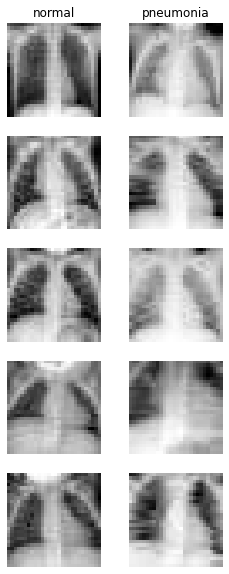

In [58]:
plot_originals, plot_DCGAN, plot_DAE, plot_CVAE, plot_geometric = all_results['pneumoniamnist']['plots']
plot_originals

Using the DCGAN, the generated images for each class manage to emulate the originals, as we can observe in the next plot. 

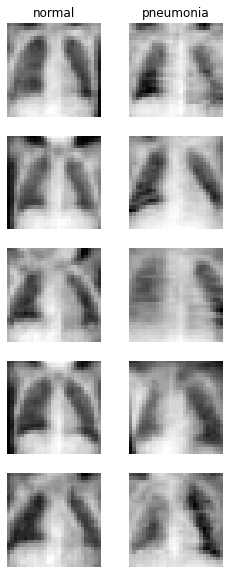

In [60]:
plot_DCGAN


The DAE also provides good results. We can see in the next image, that the reconstructions resemble the original data. 

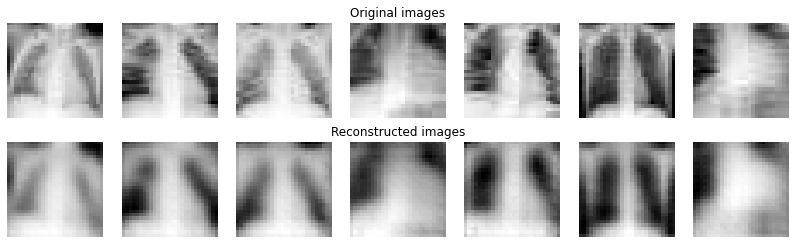

In [62]:
plot_DAE

The Convolutional Variational Autoencoder partially achieves good results (see next plot). The generated images resemble the originals. Nevertheless, the patterns for each class are not as evident as in the true data. For instance, some of the images that were generated for the class 'normal' could be attributed to the 'pneumonia' class. 

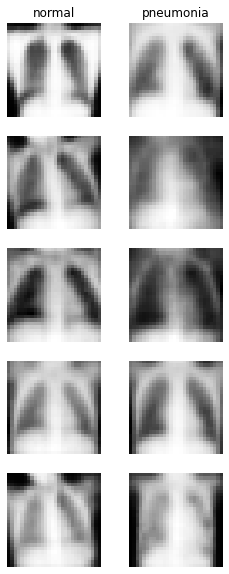

In [63]:
plot_CVAE

In the next plot we see some examples of the flipped and rotated images. 

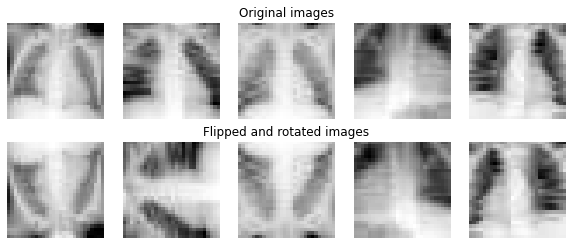

In [64]:
plot_geometric

In the next table, we see that in general none of the techniques helped on improving the accuracy. The test accuracy even decreased in some cases due to the data augmentation. 

In [61]:
all_results['pneumoniamnist']['accuracy_results']

,accuracy_train,accuracy_val,accuracy_test
Original Data,0.981946,0.963740,0.831731
DCGAN,0.987822,0.963740,0.834936
DAE,0.899462,0.965649,0.822115
CVAE,0.896488,0.956107,0.806090
Geometric augmentation,0.895639,0.952290,0.806090


### BreastMNIST

This dataset also involved a binary classification task. The key aspect of this data is that it was the smallest, with only 780 images in total (for training, validation and testing). Also, we can suspect that the classification could be harder. In the next plot we see some examples of its images. For a non-trained eye, it is not that obvious which image would correspond to each class.   

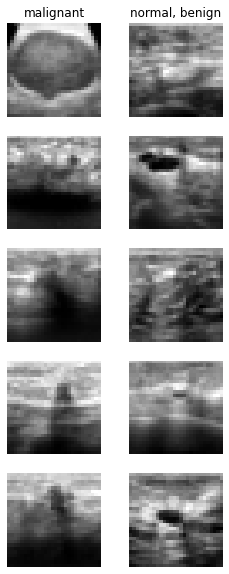

In [65]:
plot_originals, plot_DCGAN, plot_DAE, plot_CVAE, plot_geometric = all_results['breastmnist']['plots']
plot_originals

The next plot shows some examples of the images generated by the DCGAN for each class. We observe that the results are not as good as in the previous dataset. One of the reasons for this outcome can be the small size of the dataset.

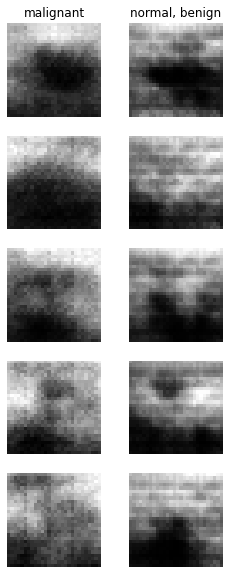

In [66]:
plot_DCGAN


The results for the denoising autoencoder are not particularlly good either. The reconstructions contain to much blurr as we see in the next plot. 

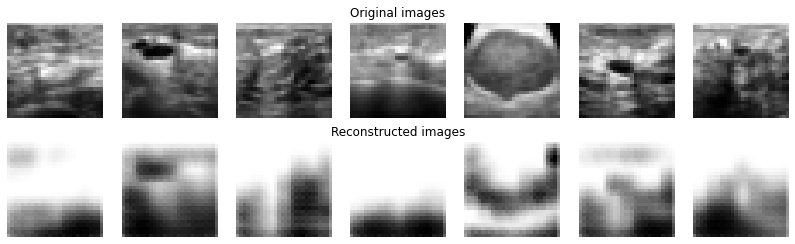

In [67]:
plot_DAE

We observe even worse results for the convolutional variational autoencoder. 

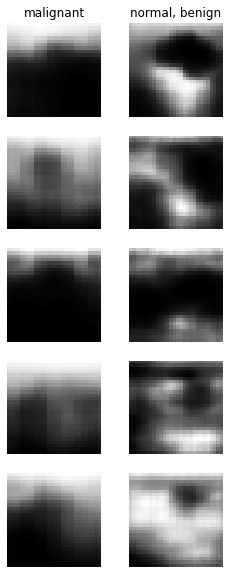

In [68]:
plot_CVAE

Here we see some results of the flipping and rotating.

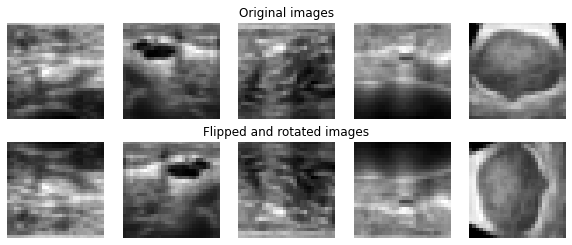

In [69]:
plot_geometric

None of the techniques improved the accuracy of the model. Interestingly, the training accuracy increased when using DCGAN as data augmentation technique, which can indicate the tendency of the dataset to overfit then using this data augmentation tool.  

In [70]:
all_results['breastmnist']['accuracy_results']

,accuracy_train,accuracy_val,accuracy_test
Original Data,0.871795,0.833333,0.833333
DCGAN,0.944988,0.858974,0.820513
DAE,0.835366,0.820513,0.826923
CVAE,0.831707,0.858974,0.833333
Geometric augmentation,0.835366,0.858974,0.833333


### BloodMNIST

Now we present the results for one of the multi-class classification task for 3 channel images. In the next plot we observe examples of true images for every class. 

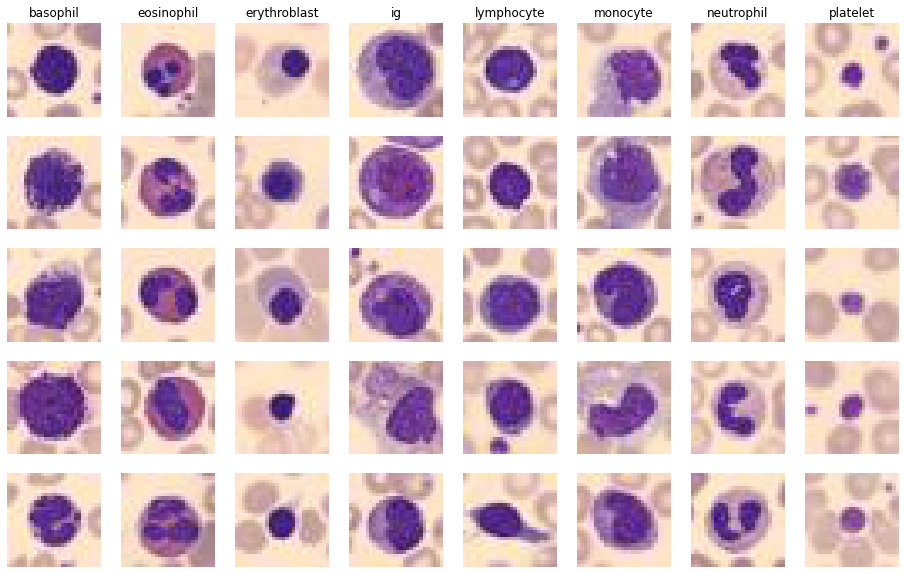

In [71]:
plot_originals, plot_DCGAN, plot_DAE, plot_CVAE, plot_geometric = all_results['bloodmnist']['plots']
plot_originals

The DCGAN manages to provide good generated images for each of the classes (see image below).

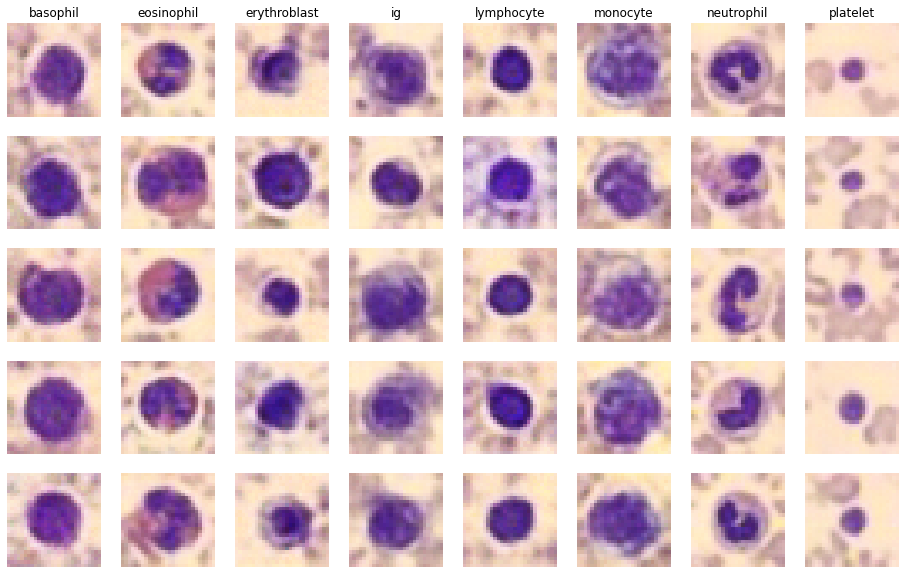

In [72]:
plot_DCGAN


The denoising autoencoder also shows good reconstructions of the images. 

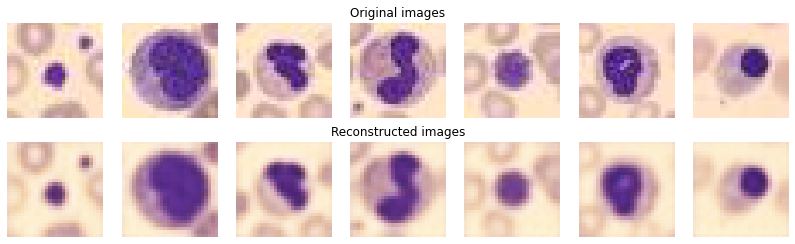

In [73]:
plot_DAE

The variational autoencoder does not shows so good results. In particular it does not capture correctly the background, and its representations of the classes are too blurry.  

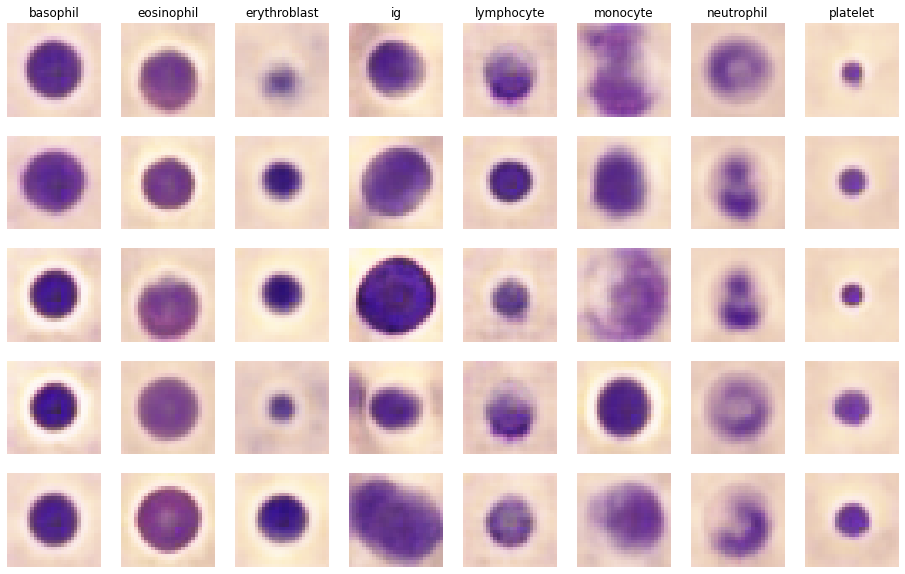

In [74]:
plot_CVAE

Here is an example of some flipped and rotated images. 

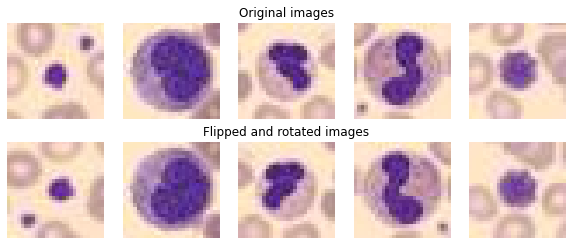

In [75]:
plot_geometric

Once more, none of the techniques aids in improving the accuracy. Surprisingly, the CVAE is the only one that increases slightly the validation and test accuracy. Nevertheless, this improvement is not big enough determine the CVAE as a clear winner. 

In [76]:
all_results['bloodmnist']['accuracy_results']

,accuracy_train,accuracy_val,accuracy_test
Original Data,0.976419,0.928738,0.925753
DCGAN,0.969224,0.909463,0.900029
DAE,0.704354,0.926402,0.919906
CVAE,0.709595,0.933411,0.928091
Geometric augmentation,0.705692,0.931659,0.922830


### DermaMNIST

Finally, we explore the DermaMNIST data. This is also a multi-class collection. For the non-trained eye, the classes are not obvious, as we can see in the examples of true images below.

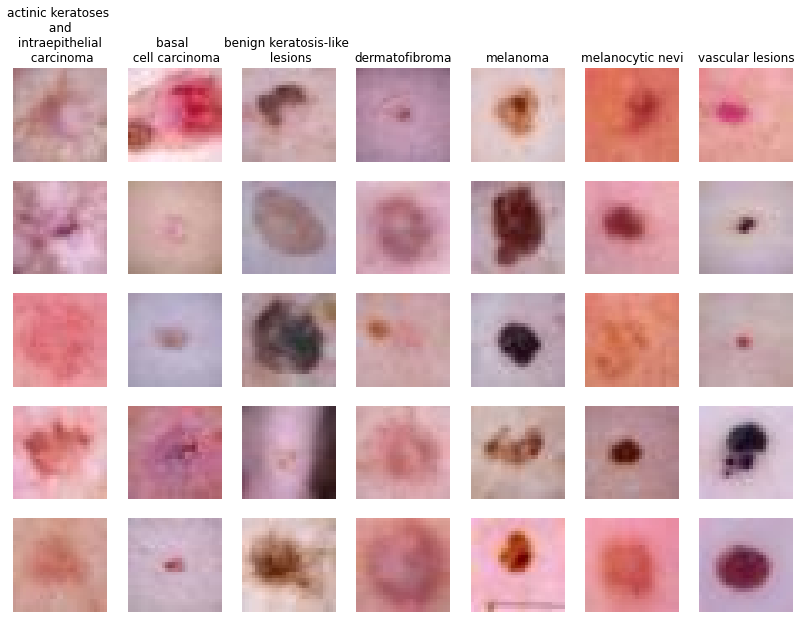

In [77]:
plot_originals, plot_DCGAN, plot_DAE, plot_CVAE, plot_geometric = all_results['dermamnist']['plots']
plot_originals

The DCGAN struggles to generate data for some classes and thrives in other ones. In the next plot we present examples of the generated images. For instance, the images generated for the 'melanocytic nevi' class resemble original images, while the 'dermatofibroma' examples totally fail to represent the class. 

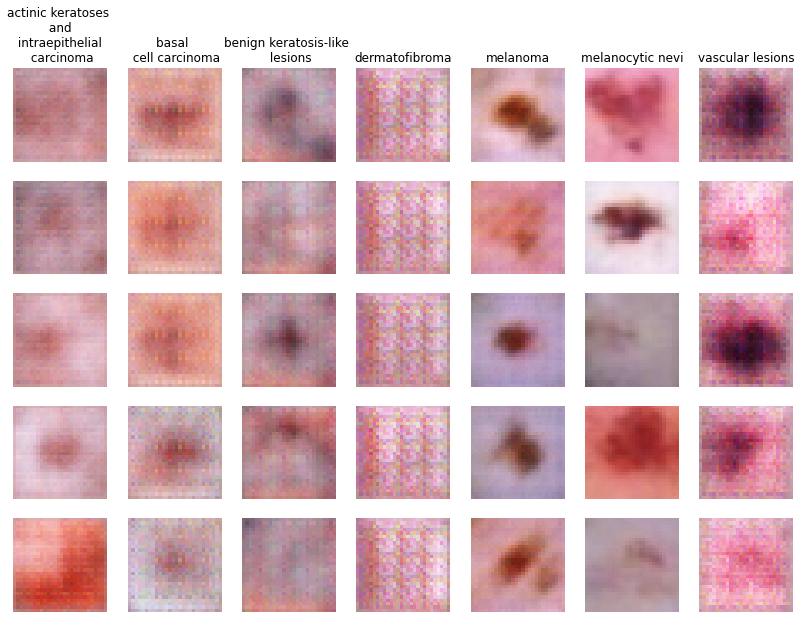

In [78]:
plot_DCGAN


The denoising autoencoder produces good reconstructed images, as we see in the plot below. 

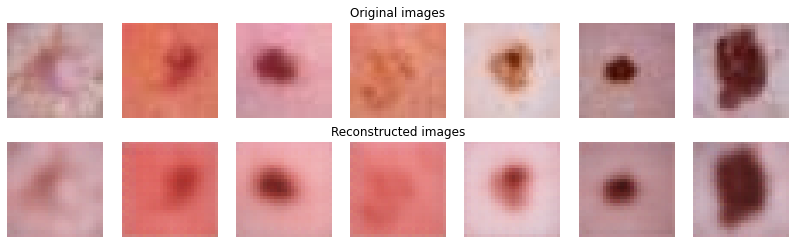

In [79]:
plot_DAE

The CVAE, similar to the DCGAN, thrives in the representation of some classes, while it fails for others. Given that the classes with good results are the same as in the DCGAN, we can assume that this outcome is a result of the size of the class. The classes with more examples are able to train better DCGANs and CVAEs.  

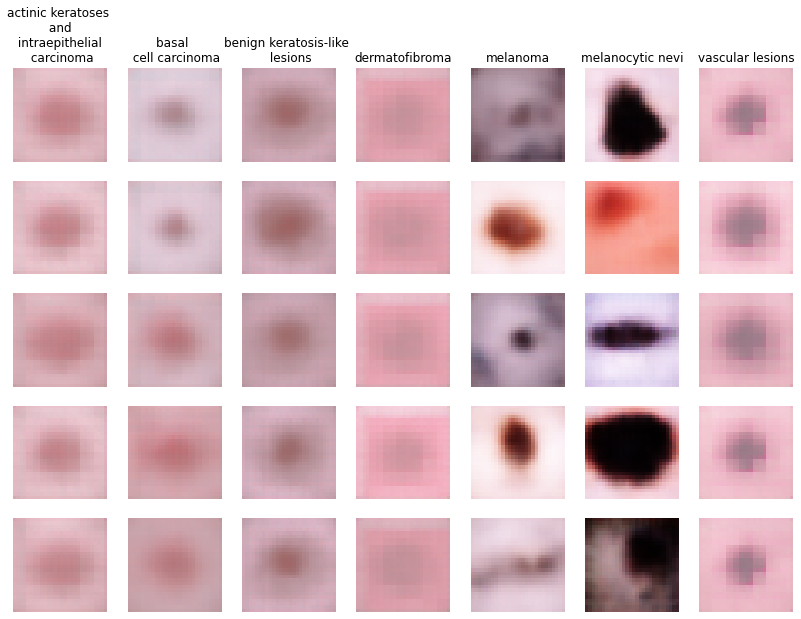

In [80]:
plot_CVAE

The next plot is an example of geometric data augmentation on this dataset. 

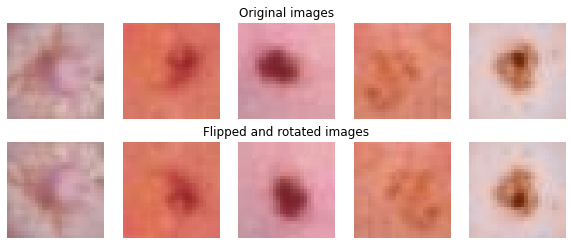

In [81]:
plot_geometric

Once more, none of the techniques helped to increase the accuracy. 

In [82]:
all_results['dermamnist']['accuracy_results']

,accuracy_train,accuracy_val,accuracy_test
Original Data,0.788497,0.746760,0.743641
DCGAN,0.878188,0.741775,0.733666
DAE,0.746932,0.742772,0.742145
CVAE,0.748644,0.740778,0.727681
Geometric augmentation,0.746361,0.735793,0.721696


## Conclusion

We used four data augmentation techniques with the aim of increasing the quality of our training set and observing better accuracy results on an image classifier. For all the datasets, none of the techniques helped to improve the accuracy of the model. There can be several causes for this outcome. First, in some cases, the data generation techniques do not manage to emulate the true data. This is the case when the data augmentation technique has little data to train. In other cases, the dataset could be particularly complex, and more robust architectures could be necessary. Second, in all the cases, we augmented the data on 50%, perhaps more generated data it's necessary.  

## References

Jin, H., Song, Q., & Hu, X. (2019). Auto-keras: An efficient neural architecture search system. Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, 1946–1956.

Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. ArXiv Preprint ArXiv:1312.6114.

Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. ArXiv Preprint ArXiv:1511.06434.

Shorten, C., & Khoshgoftaar, T. M. (2019). A survey on Image Data Augmentation for Deep Learning. Journal of Big Data, 6(1), 60. https://doi.org/10.1186/s40537-019-0197-0

Yang, J., Shi, R., Wei, D., Liu, Z., Zhao, L., Ke, B., Pfister, H., & Ni, B. (2021). MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification. ArXiv Preprint ArXiv:2110.14795.
